In [ ]:
# %load ./rbm.py
import torch


class RBM():

    def __init__(self, num_visible, num_hidden, k, learning_rate=1e-3, momentum_coefficient=0.5, weight_decay=1e-4, use_cuda=True):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.learning_rate = learning_rate
        self.momentum_coefficient = momentum_coefficient
        self.weight_decay = weight_decay
        self.use_cuda = use_cuda

        self.weights = torch.randn(num_visible, num_hidden) * 0.1
        self.visible_bias = torch.ones(num_visible) * 0.5
        self.hidden_bias = torch.zeros(num_hidden)

        self.weights_momentum = torch.zeros(num_visible, num_hidden)
        self.visible_bias_momentum = torch.zeros(num_visible)
        self.hidden_bias_momentum = torch.zeros(num_hidden)

        if self.use_cuda:
            self.weights = self.weights.cuda()
            self.visible_bias = self.visible_bias.cuda()
            self.hidden_bias = self.hidden_bias.cuda()

            self.weights_momentum = self.weights_momentum.cuda()
            self.visible_bias_momentum = self.visible_bias_momentum.cuda()
            self.hidden_bias_momentum = self.hidden_bias_momentum.cuda()

    def sample_hidden(self, visible_probabilities):
        print(visible_probabilities.shape)
        print(self.weights.shape)
        hidden_activations = torch.matmul(visible_probabilities, self.weights) + self.hidden_bias
        hidden_probabilities = self._sigmoid(hidden_activations)
        return hidden_probabilities

    def sample_visible(self, hidden_probabilities):
        visible_activations = torch.matmul(hidden_probabilities, self.weights.t()) + self.visible_bias
        visible_probabilities = self._sigmoid(visible_activations)
        return visible_probabilities

    def contrastive_divergence(self, input_data):
        # Positive phase
        positive_hidden_probabilities = self.sample_hidden(input_data)
        positive_hidden_activations = (positive_hidden_probabilities >= self._random_probabilities(self.num_hidden)).float()
        positive_associations = torch.matmul(input_data.t(), positive_hidden_activations)

        # Negative phase
        hidden_activations = positive_hidden_activations

        for step in range(self.k):
            visible_probabilities = self.sample_visible(hidden_activations)
            hidden_probabilities = self.sample_hidden(visible_probabilities)
            hidden_activations = (hidden_probabilities >= self._random_probabilities(self.num_hidden)).float()

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        negative_associations = torch.matmul(negative_visible_probabilities.t(), negative_hidden_probabilities)

        # Update parameters
        self.weights_momentum *= self.momentum_coefficient
        self.weights_momentum += (positive_associations - negative_associations)

        self.visible_bias_momentum *= self.momentum_coefficient
        self.visible_bias_momentum += torch.sum(input_data - negative_visible_probabilities, dim=0)

        self.hidden_bias_momentum *= self.momentum_coefficient
        self.hidden_bias_momentum += torch.sum(positive_hidden_probabilities - negative_hidden_probabilities, dim=0)

        batch_size = input_data.size(0)

        self.weights += self.weights_momentum * self.learning_rate / batch_size
        self.visible_bias += self.visible_bias_momentum * self.learning_rate / batch_size
        self.hidden_bias += self.hidden_bias_momentum * self.learning_rate / batch_size

        self.weights -= self.weights * self.weight_decay  # L2 weight decay

        # Compute reconstruction error
        error = torch.sum((input_data - negative_visible_probabilities)**2)

        return error

    def _sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def _random_probabilities(self, num):
        random_probabilities = torch.rand(num)

        if self.use_cuda:
            random_probabilities = random_probabilities.cuda()

        return random_probabilities




In [1]:
from PIL import Image
#from IPython.display import display, Image

In [2]:
# %load mnist_example.py
import numpy as np
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [3]:
import redis
import io
import base64

def decoder(img_str):
    return base64.b64encode(img_str).decode('utf-8')

def encoder(img_str):
    return base64.b64decode(img_str.decode('utf-8'))

def fetch_ring_im(ind, redis):
    img_str = redis.get('frame_%05d' % ind)
    enc_str = encoder(img_str)
    img = Image.open(io.BytesIO(enc_str))
    return img

def fetch_tensor_im(ind, redis, t):
    im = fetch_ring_im(ind, redis)
    t = t(im)
    return t.view(3, 720 * 1024)

In [4]:
VISIBLE_UNITS = 720 * 1024
HIDDEN_UNITS = 640
EPOCHS=1
BATCH_SIZE=3
CD_K=2
CUDA=False

In [ ]:
from rbm import RBM
rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K, use_cuda=CUDA)
print('RBM Initialized...')

In [5]:
frame = 0
ringsize = 10000
r = redis.StrictRedis(host='redis')
t = torchvision.transforms.ToTensor()

In [ ]:
while True:
    tens = fetch_tensor_im(frame, r, t)
    data_loader = torch.utils.data.DataLoader(tens, batch_size=BATCH_SIZE)
    ########## TRAINING RBM ##########
    print('Training RBM on frame_%05d...' % frame)
    for epoch in range(EPOCHS):
        epoch_error = 0.0

        for batch in data_loader:
            #batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data

            if CUDA:
                batch = batch.cuda()

            batch_error = rbm.contrastive_divergence(batch)

            epoch_error += batch_error

        print('Epoch Error (epoch=%d): %.4f' % (epoch, epoch_error))
    frame += 1
    if frame > ringsize:
        frame = 0

In [6]:
import pickle
with open('rbm.pkl', 'rb') as pf:
    rbm = pickle.load(pf)

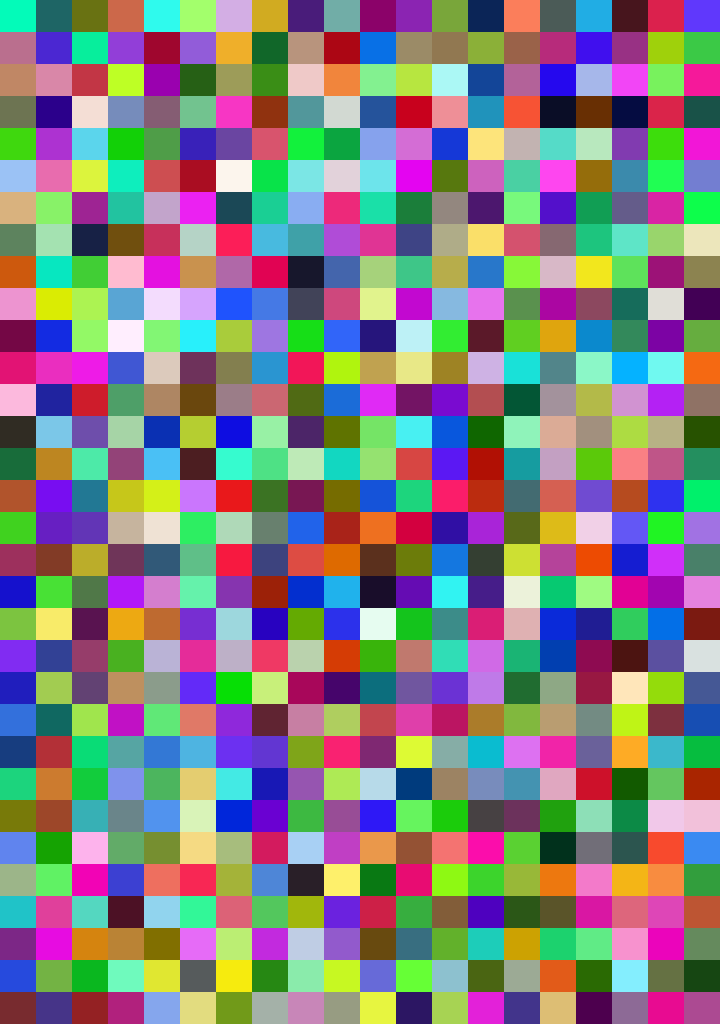

In [7]:
rand_ = torch.randn(3, 640)
proj_t = torch.Tensor(rand_)
stamp_e = torchvision.transforms.ToPILImage()(proj_t.view(3, 32, 20))
stamp_e.resize([720, 1024])

In [8]:
sample = rbm.sample_visible(rand_)
sample


 0.6315  0.8161  0.2039  ...   0.4844  0.9099  0.5657
 0.4591  0.1393  0.3695  ...   0.0424  0.3647  0.4841
 0.3223  0.9338  0.1898  ...   0.9326  0.5875  0.9757
[torch.FloatTensor of size 3x737280]

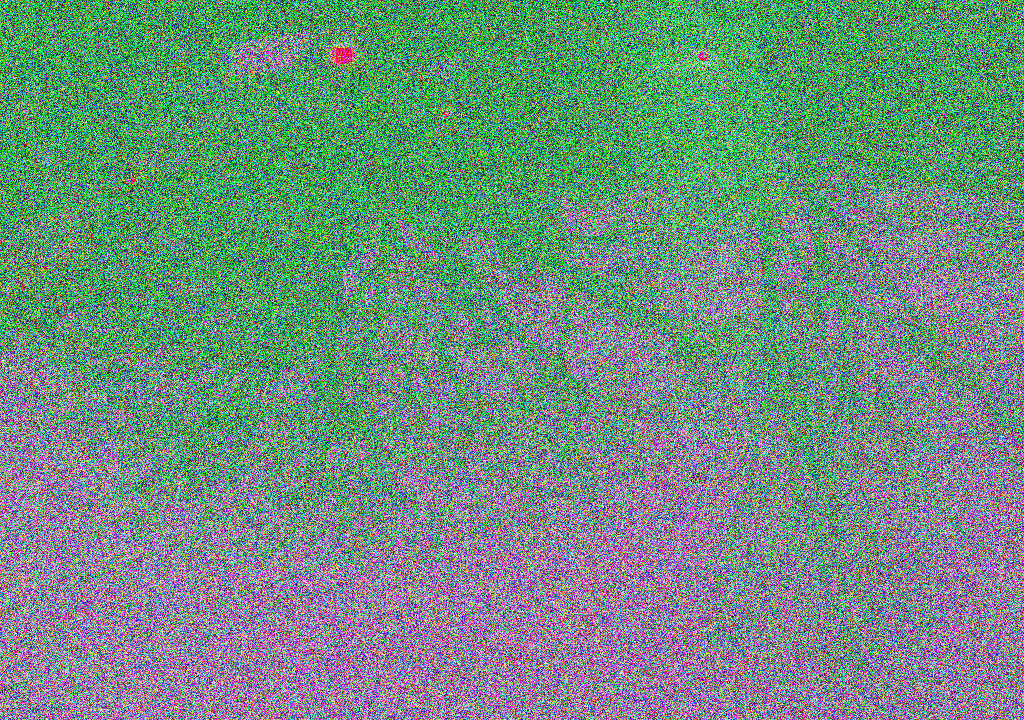

In [9]:
sample = rbm.sample_visible(torch.randn(3, 640))
torchvision.transforms.ToPILImage()(sample.view(3, 720, 1024))

In [10]:
simply_flattened = fetch_tensor_im(125, r, t)

In [11]:
l = rbm.sample_hidden(simply_flattened)
torchvision.transforms.ToPILImage()(l.view(3, 32, 20))

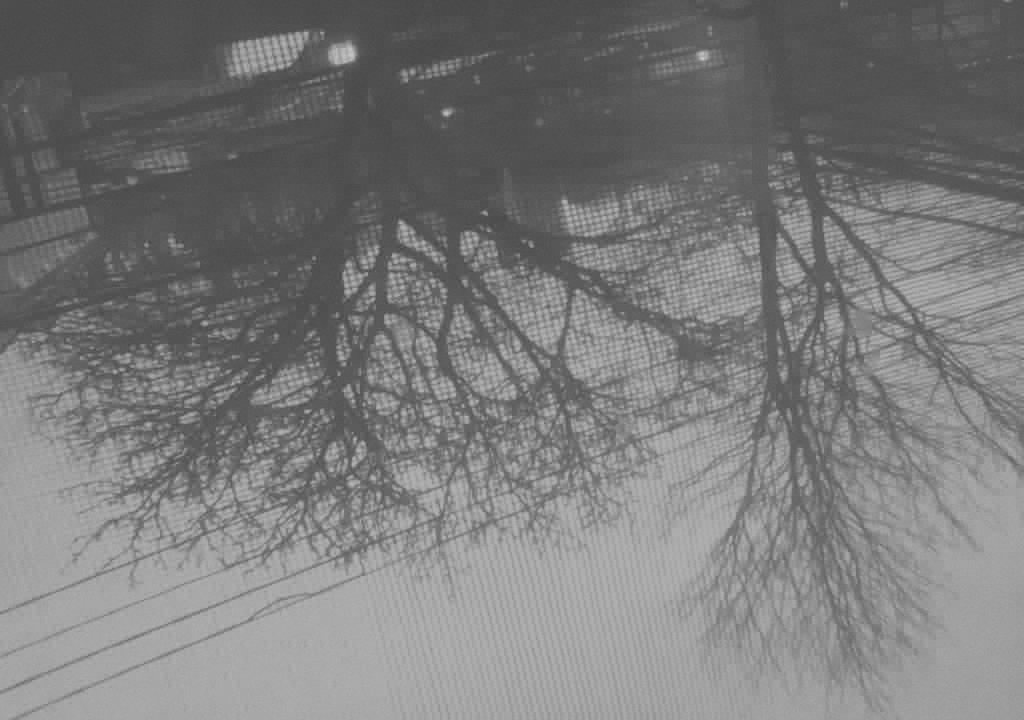

In [12]:
v = rbm.sample_visible(l)
torchvision.transforms.ToPILImage()(v.view(3, 720, 1024))

In [13]:
la = rbm.sample_hidden(simply_flattened)
la_n = la.numpy()
co = np.corrcoef(la_n)

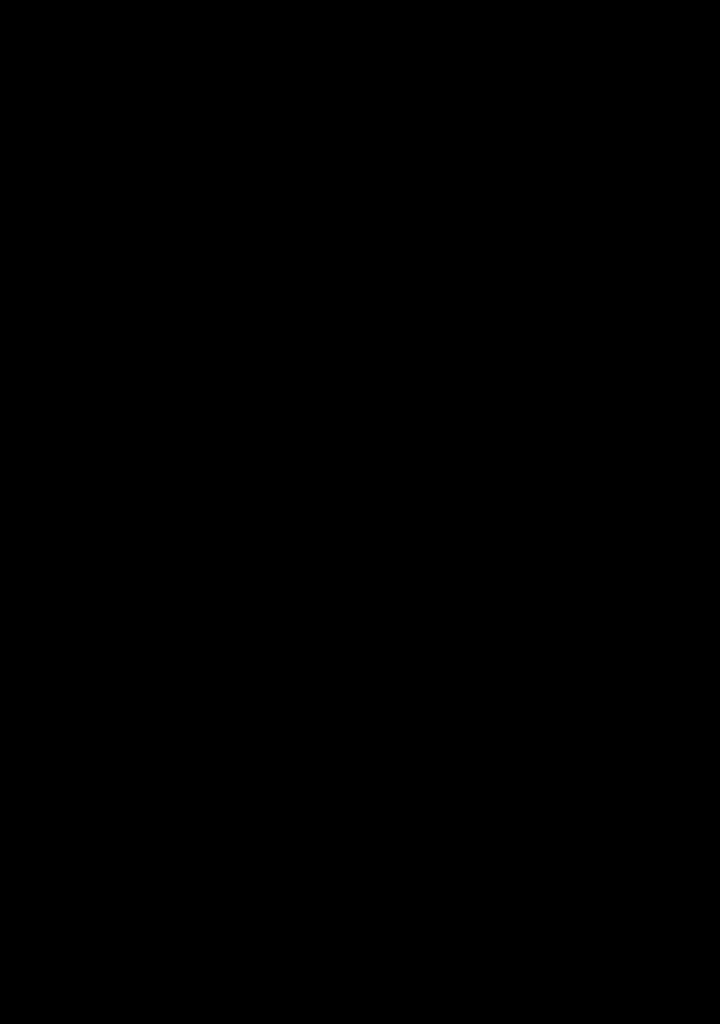

In [14]:
stamp = torchvision.transforms.ToPILImage()(la.view(3, 32, 20))
stamp.resize([720, 1024])

In [15]:
%matplotlib inline

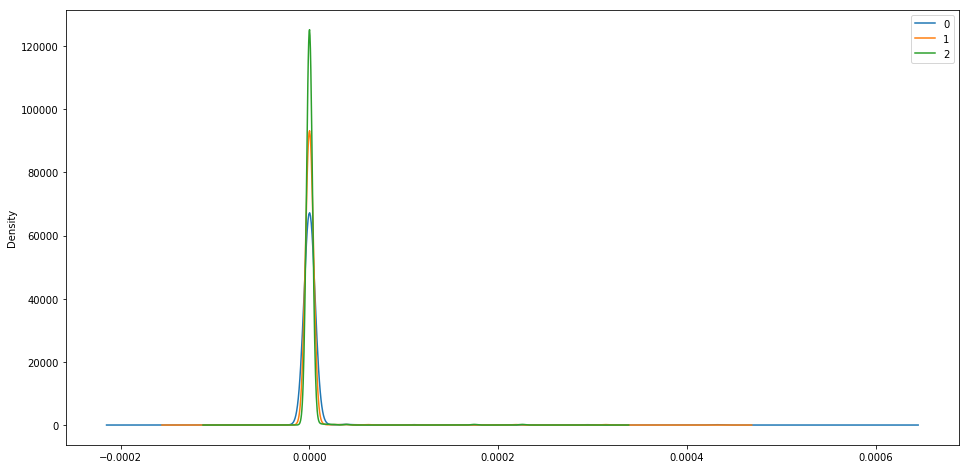

In [16]:
import pandas as pd
df = pd.DataFrame(la_n)
p = df.T.plot.kde(figsize=(16,8))

In [17]:
# from scipy import stats
# stats.gaussian_kde?

In [18]:
# kde = stats.gaussian_kde(la_n, )

In [19]:
from sklearn.neighbors import KernelDensity
KernelDensity

sklearn.neighbors.kde.KernelDensity

In [41]:
kde = KernelDensity(
    bandwidth=0.8
).fit(la_n.T)
kde

KernelDensity(algorithm='auto', atol=0, bandwidth=0.8, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

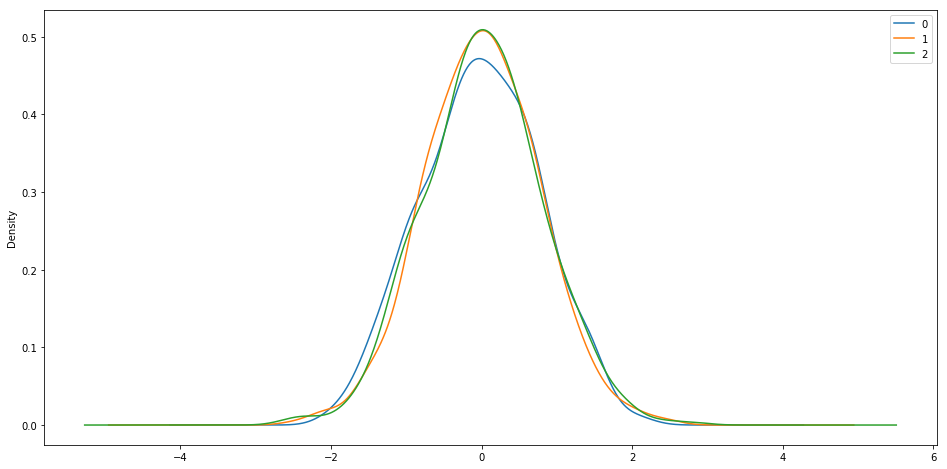

In [42]:
# projected_image = kde.resample(640)
projected_image = kde.sample(640).T
pd.DataFrame(projected_image).T.plot.kde(figsize=(16,8))

In [43]:
la_n.shape == projected_image.shape, np.any(la_n == projected_image)

(True, False)

In [44]:
projected_image_squashed = projected_image.copy()
projected_image_squashed[projected_image_squashed > 1] = 1
projected_image_squashed[projected_image_squashed < 0] = 0

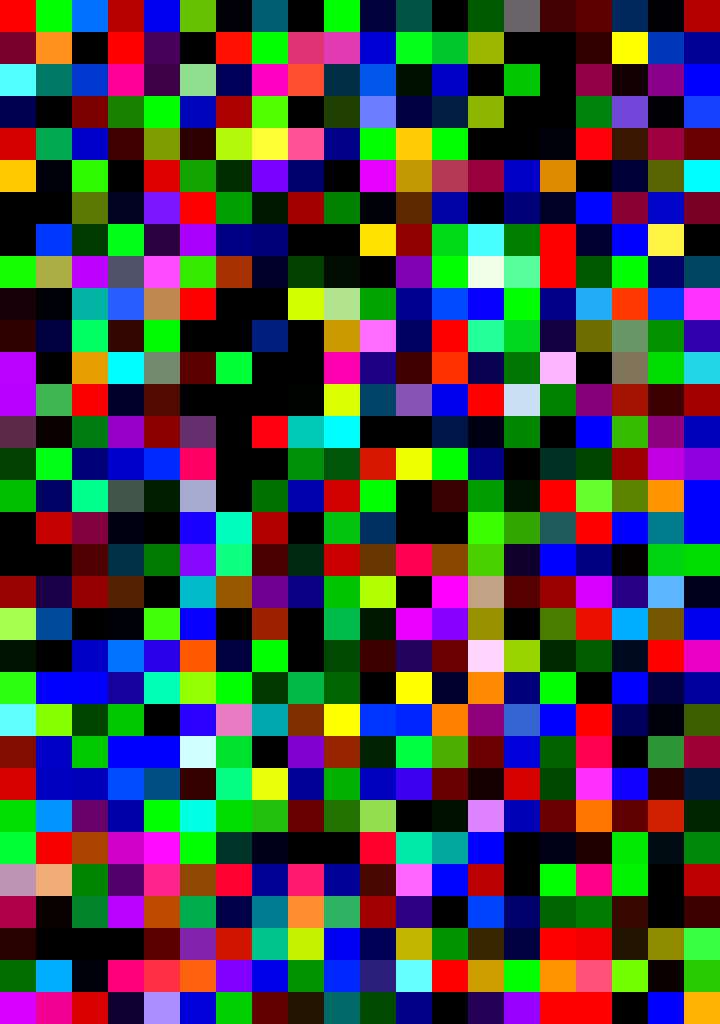

In [45]:
proj_t = torch.Tensor(projected_image_squashed)
stamp_e = torchvision.transforms.ToPILImage()(proj_t.view(3, 32, 20))
stamp_e.resize([720, 1024])

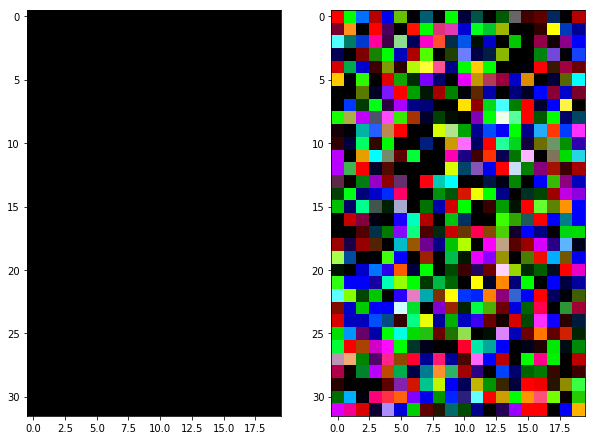

In [46]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(1,2, figsize=(10, 10))

axarr[0].imshow(stamp)
axarr[1].imshow(stamp_e)

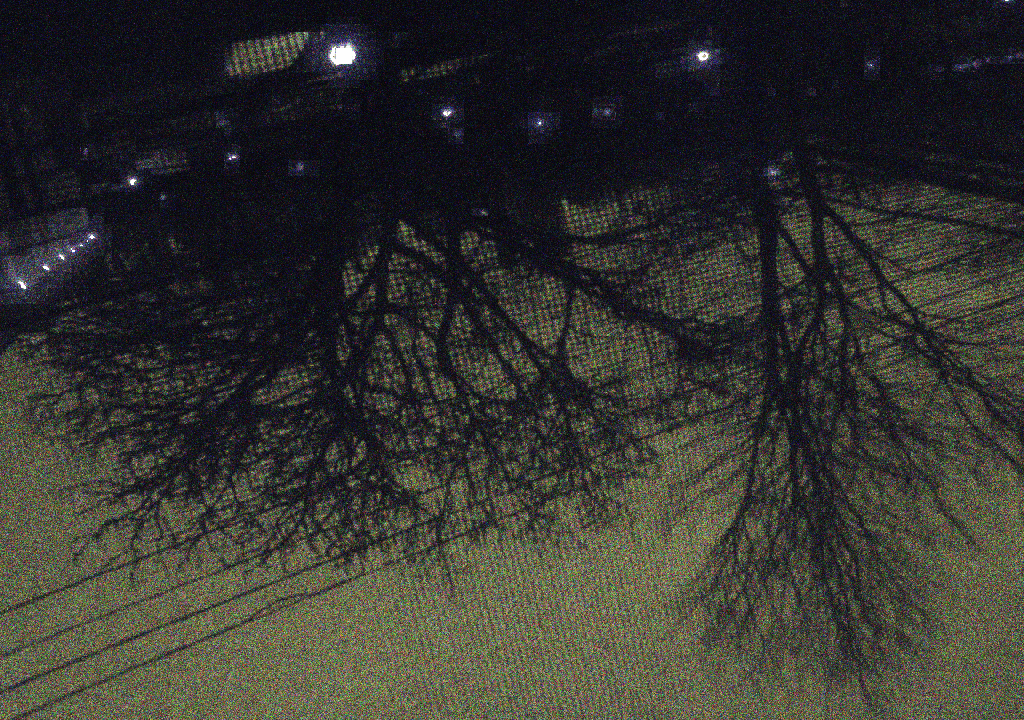

In [47]:
vv = rbm.sample_visible(proj_t)
torchvision.transforms.ToPILImage()(vv.view(3, 720, 1024))

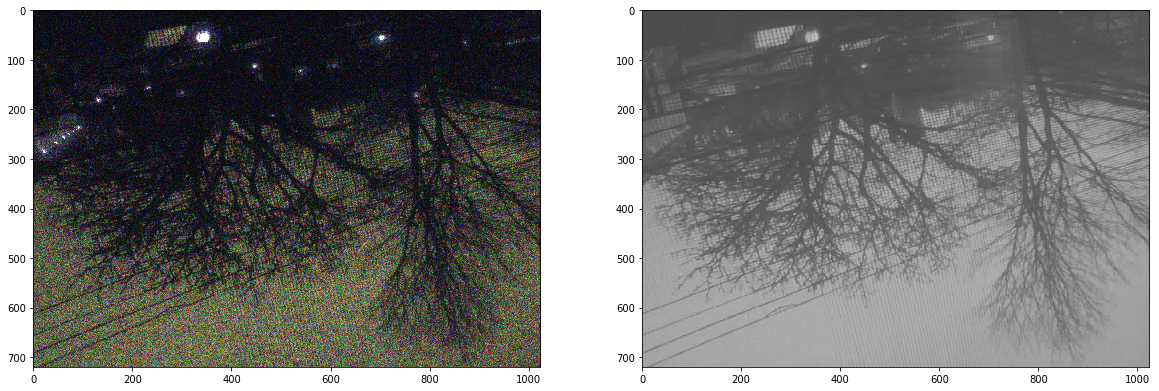

In [48]:
a = torchvision.transforms.ToPILImage()(vv.view(3, 720, 1024))
b = torchvision.transforms.ToPILImage()(v.view(3, 720, 1024))

fig, axarr = plt.subplots(1,2, figsize=(20, 10))

axarr[0].imshow(a)
axarr[1].imshow(b)

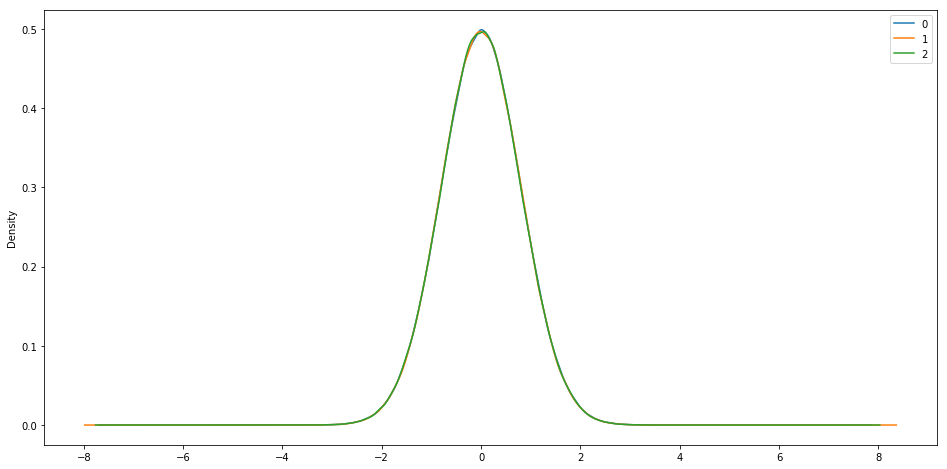

In [49]:
# projected_image = kde.resample(640)
projected_image_sequence = kde.sample(640 * 1440).T
pd.DataFrame(projected_image_sequence).T.plot.kde(figsize=(16,8))

In [50]:
a = projected_image_sequence[:, 0*640:1*640] 
b = projected_image_sequence[:, 1439*640:1440*640]
a.shape, b.shape
np.any(a == b)

False

In [51]:
from tqdm import tnrange, tqdm_notebook
for i in tnrange(1440, desc='frames'):
    p = projected_image_sequence[:, i*640:(i+1)*640]
    p[p > 1] = 1
    p[p < 0] = 0
    proj_t = torch.Tensor(p)
    pp = rbm.sample_visible(proj_t)
    ipp = torchvision.transforms.ToPILImage()(pp.view(3, 720, 1024))
    ipp.save('./image/%05i_projected_shimmer.png' % i)

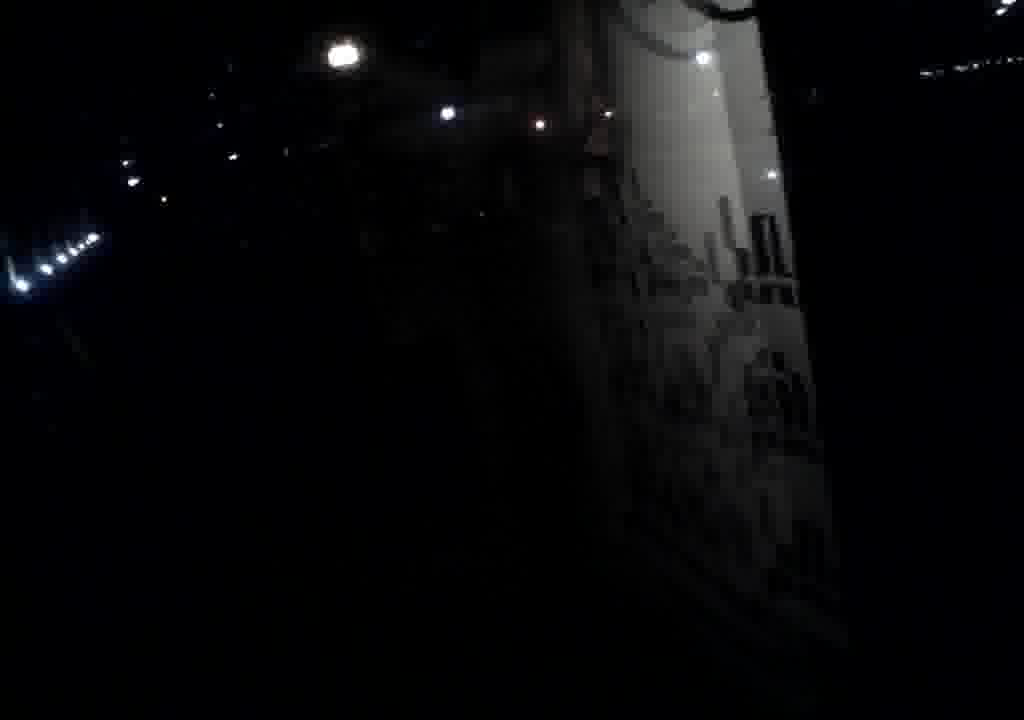

In [52]:
im = fetch_ring_im(frame, r)
im

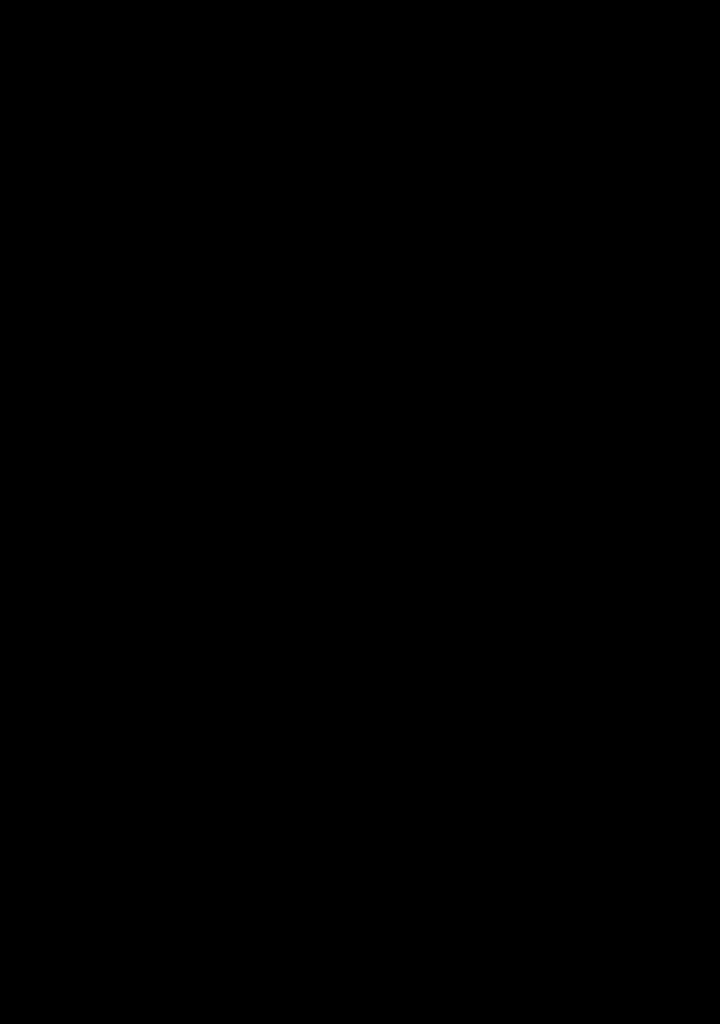

In [53]:
tens = t(im)
s = rbm.sample_hidden(tens.view(3, 720 * 1024))
stamp_e = torchvision.transforms.ToPILImage()(s.view(3, 32, 20))
stamp_e.resize([720, 1024])

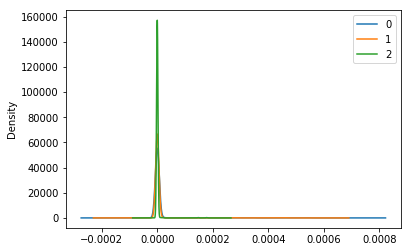

In [56]:
pd.DataFrame(s.numpy()).T.plot.kde()

In [ ]:
import pickle
with open('rbm_l.pkl', 'wb') as rbm_file:
    pickle.dump(rbm, rbm_file)

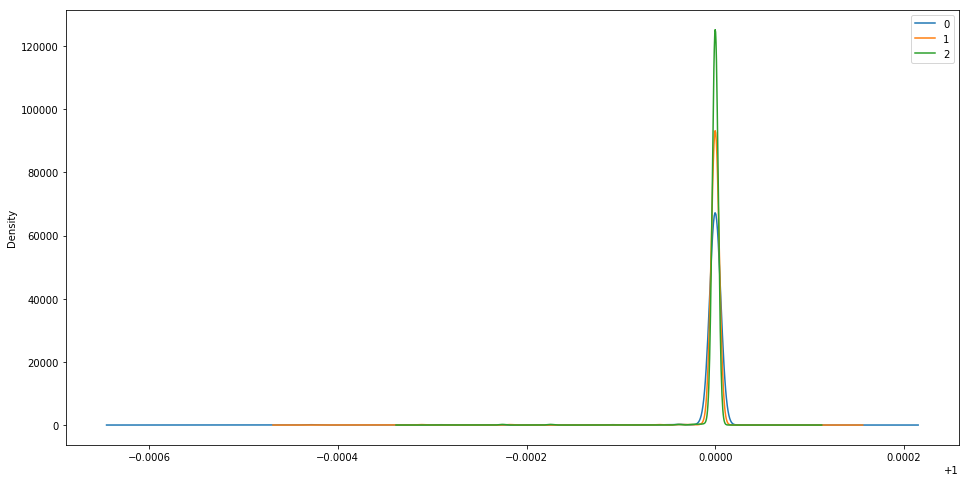

In [61]:
inv_la = 1 - la
df = pd.DataFrame(inv_la.numpy())
p = df.T.plot.kde(figsize=(16,8))

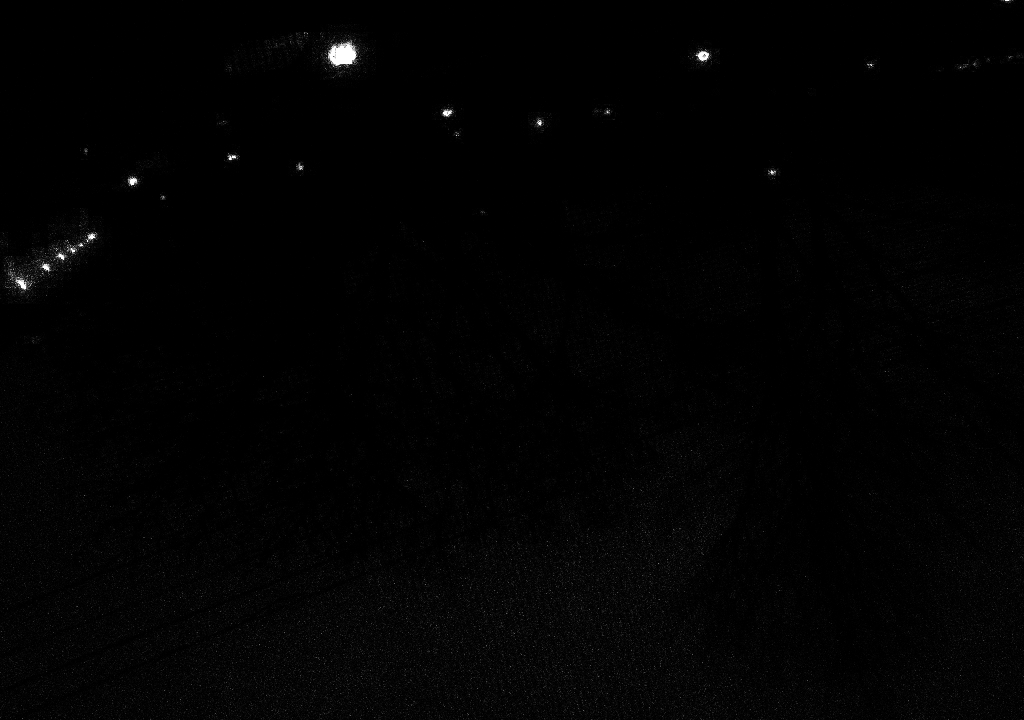

In [66]:
vvv = rbm.sample_visible(inv_la)
torchvision.transforms.ToPILImage()(vvv.view(3, 720, 1024))

In [118]:
import numpy as np
x, _, _ = np.mgrid[0:1:1440j, 0:3:1, 0:640:1]

In [119]:
from tqdm import tnrange, tqdm_notebook
for i in tnrange(1440, desc='frames'):
    p = x[i]
    p[p > 1] = 1
    p[p < 0] = 0
    proj_t = torch.Tensor(p)
    pp = rbm.sample_visible(proj_t)
    ipp = torchvision.transforms.ToPILImage()(pp.view(3, 720, 1024))
    ipp.save('./image/linmove/%05i_projected_linmove.png' % i)